# Over / Under Sampling
- 오분류되는 41, 42, 43, 44만 따로 뽑아내서 서로 구분하는 모델 만들 수 있는지 확인
- 결론: 불가
    - Dept feature는 변별력이 약함. 
    - Dept 활용하여 가중치 주었으나 효과없음.
    - Fineline feature까지 사용하여야 하나 Memory 부족

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder

__AUTHOR__ = 'Kirgsn'

class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe to in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        """
        if conv_table is None:
            self.conversion_table = \
                {'int': [np.int8, np.int16, np.int32, np.int64],
                 'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                 'float': [np.float16, np.float32, ]}
        else:
            self.conversion_table = conv_table

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=-1)(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)

        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):

        # skip NaNs
        if s.isnull().any():
            if verbose:
                print(colname, 'has NaNs - Skip..')
            return s

        # detect kind of type
        coltype = s.dtype
        if np.issubdtype(coltype, np.integer):
            conv_key = 'int' if s.min() < 0 else 'uint'
        elif np.issubdtype(coltype, np.floating):
            conv_key = 'float'
        else:
            if verbose:
                print(colname, 'is', coltype, '- Skip..')
            print(colname, 'is', coltype, '- Skip..')
            return s

        # find right candidate
        for cand, cand_info in self._type_candidates(conv_key):
            if s.max() <= cand_info.max and s.min() >= cand_info.min:

                if verbose:
                    print('convert', colname, 'to', str(cand))
                return s.astype(cand)

        # reaching this code is bad. Probably there are inf, or other high numbs
        print(("WARNING: {} " 
               "doesn't fit the grid with \nmax: {} "
               "and \nmin: {}").format(colname, s.max(), s.min()))
        print('Dropping it..')
        

df = pd.read_csv("train.csv")

reducer = Reducer()
df = reducer.reduce(df)

c = df['DepartmentDescription'].isnull()
df.loc[c, 'DepartmentDescription'] = 'Na'
df['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']
df_s = df.iloc[:, [0, 1, 5, -1]]
df_s = df_s.drop_duplicates(['VisitNumber', 'DepartmentDescription']).reset_index(drop=True)

# 가중치 테이블
data = df.iloc[:, [0, 1, 5, -1]].drop_duplicates(['VisitNumber', 'DepartmentDescription'])
sub = data.groupby(['TripType', 'DepartmentDescription'], as_index=False).agg('sum').iloc[:, [0,1,3]]
c = sub['TripType'] == sub['TripType'].unique()[0]
base = minmax_scale(sub[c]['sum'])

for i in range(1, 38):
    c = sub['TripType'] == sub['TripType'].unique()[i]
    base = np.hstack([base, minmax_scale(sub[c]['sum'])]) 
    
sub['minmax'] = pd.Series(base)

ls = df['TripType'].unique()
temp = df_s.copy()

for i in ls:
    c = sub['TripType'] == i
    temp = temp.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
    col_name = "{}_sum".format(i)
    temp.loc[:, col_name] = temp['sum'] * temp['minmax']
    temp.drop('minmax', axis=1, inplace=True)

test = temp.fillna(-0.000001).groupby(['VisitNumber', 'TripType'], as_index=False).agg(sum)

x = test.merge(df_s.pivot('VisitNumber', 'DepartmentDescription', 'sum').fillna(0), on='VisitNumber').set_index('VisitNumber').drop(['TripType', 'sum', 'HEALTH AND BEAUTY AIDS'], axis=1)
y = test['TripType']

# mapping
lab4 = {41: 1, 42: 2, 43:3, 44: 4}
y_lab = y.map(lab4).fillna(5)

# oversampling
er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(x, y_lab)
er.fit(X_samp, y_samp)

In [56]:
x = test.merge(df_s.pivot('VisitNumber', 'DepartmentDescription', 'sum').fillna(0), on='VisitNumber').set_index('VisitNumber').drop('TripType', axis=1)
y = test['TripType']
lab4 = {41: 1, 42: 2, 43:3, 44: 4}
y_lab = y.map(lab4).fillna(5)

In [9]:
from imblearn.over_sampling import RandomOverSampler

er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(x, y_lab)
er.fit(X_samp, y_samp)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [6]:
from imblearn.over_sampling import RandomOverSampler
x = test.merge(df_s.pivot('VisitNumber', 'DepartmentDescription', 'sum').fillna(0), on='VisitNumber').set_index('VisitNumber').drop('TripType', axis=1)
y = test['TripType']
lab4 = {41: 1, 42: 2, 43:3, 44: 4}
y_lab = y.map(lab4).fillna(5)
X_train, X_test, y_train, y_test = train_test_split(x, y_lab, random_state=0)
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(X_test, y_test)

# test

In [57]:
# not_in_train = [i for i in test_x.columns if i not in x.columns]

# not_in_test = [i for i in x.columns if i not in test_x.columns]

total_train = train.drop(columns=not_in_test)

# total_test = test.drop(columns=not_in_train)

In [ ]:
df_test = pd.read_csv("test.csv")

reducer = Reducer()
df_test = reducer.reduce(df_test)
df_test.drop(['Weekday', 'Upc', 'FinelineNumber'], inplace=True, axis=1)

c = df_test['DepartmentDescription'].isnull()
df_test.loc[c, 'DepartmentDescription'] = 'Na'
df_test['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']

df_s1 = df_test.iloc[:, [0,2, -1]]
df_s1 = df_test.drop_duplicates(['VisitNumber', 'DepartmentDescription']).reset_index(drop=True)

temp1 = df_test.copy()

for i in ls:
    c = sub['TripType'] == i
    temp1 = temp1.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
    col_name = "{}_sum".format(i)
    temp1.loc[:, col_name] = temp1['sum'] * temp1['minmax']
    temp1.drop('minmax', axis=1, inplace=True)
test1 = temp1[:-1].fillna(-0.000001).groupby('VisitNumber',).agg(sum).iloc[:, 2:]

test_x = test1.merge(df_s1.pivot('VisitNumber', 'DepartmentDescription', 'sum').fillna(0), on='VisitNumber')


In [19]:
df_test = pd.read_csv("test.csv")

reducer = Reducer()
df_test = reducer.reduce(df_test)
df_test.drop(['Weekday', 'Upc', 'FinelineNumber'], inplace=True, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653646 entries, 0 to 653645
Data columns (total 3 columns):
VisitNumber              653646 non-null uint32
ScanCount                653646 non-null int8
DepartmentDescription    652318 non-null object
dtypes: int8(1), object(1), uint32(1)
memory usage: 8.1+ MB


In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653646 entries, 0 to 653645
Data columns (total 3 columns):
VisitNumber              653646 non-null uint32
ScanCount                653646 non-null int8
DepartmentDescription    652318 non-null object
dtypes: int8(1), object(1), uint32(1)
memory usage: 8.1+ MB


In [24]:
c = df_test['DepartmentDescription'].isnull()
df_test.loc[c, 'DepartmentDescription'] = 'Na'
df_test['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']

In [43]:
df_test.head()

,VisitNumber,ScanCount,DepartmentDescription,sum
0,1,1,SHOES,-1.0
1,1,1,DAIRY,1.0
2,1,1,DAIRY,1.0
3,1,1,GROCERY DRY GOODS,18.0
4,2,1,DSD GROCERY,18.0


In [45]:
df_s1 = df_test.iloc[:, [0,2, -1]]
df_s1 = df_test.drop_duplicates(['VisitNumber', 'DepartmentDescription']).reset_index(drop=True)
df_s1.tail()

,VisitNumber,ScanCount,DepartmentDescription,sum
323627,191341,1,INFANT CONSUMABLE HARDLINES,NaN
323628,191341,1,INFANT APPAREL,NaN
323629,191348,1,SWIMWEAR/OUTERWEAR,NaN
323630,191348,1,MENS WEAR,NaN
323631,191348,1,BATH AND SHOWER,NaN


In [26]:
df_test.tail()

,VisitNumber,ScanCount,DepartmentDescription,sum
653641,191348,1,BATH AND SHOWER,NaN
653642,191348,1,BATH AND SHOWER,NaN
653643,191348,1,MENS WEAR,NaN
653644,191348,1,SWIMWEAR/OUTERWEAR,NaN
653645,191348,1,MENS WEAR,NaN


In [27]:
temp1 = df_test.copy()

for i in ls:
    c = sub['TripType'] == i
    temp1 = temp1.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
    col_name = "{}_sum".format(i)
    temp1.loc[:, col_name] = temp1['sum'] * temp1['minmax']
    temp1.drop('minmax', axis=1, inplace=True)
test1 = temp1[:-1].fillna(-0.000001).groupby('VisitNumber',).agg(sum).iloc[:, 2:]

In [50]:
test_x = test1.merge(df_s1.pivot('VisitNumber', 'DepartmentDescription', 'sum').fillna(0), on='VisitNumber')
test_x.tail()

,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,21_sum,6_sum,42_sum,7_sum,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
191338.0,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191339.0,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,-0.000005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191340.0,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191341.0,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191348.0,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,-0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
set(test_x.columns)

Index(['999_sum', '30_sum', '26_sum', '8_sum', '35_sum', '41_sum', '21_sum',
       '6_sum', '42_sum', '7_sum',
       ...
       'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY', 'SHOES',
       'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS', 'SWIMWEAR/OUTERWEAR', 'TOYS',
       'WIRELESS'],
      dtype='object', length=106)

# Final test

In [54]:
set(df['DepartmentDescription']) - df_test['DepartmentDescription']

69

In [55]:
df_test['DepartmentDescription'].nunique()

68

In [39]:
test1

,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,21_sum,6_sum,42_sum,7_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
VisitNumber,,,,,,,,,,,,,,,,,,,,,
1.0,9.517493,1.788879,2.203765,6.657023,2.105930,7.783069,0.570340,2.908867,7.508014,18.626604,...,1.106476,1.070392,2.755467,11.288995,1.287726,1.094339,4.945820,1.325192,-0.000004,13.702128
2.0,54.905248,18.297133,9.548173,38.108140,28.149519,54.380952,7.765533,14.024631,48.944948,19.470628,...,3.704720,14.303338,16.461233,32.133014,6.917505,7.471697,17.916409,7.373343,2.285712,25.611702
3.0,11.440233,7.506516,5.461794,19.465283,0.889809,33.714286,1.667057,2.098522,23.606969,1.733964,...,1.906696,2.899855,8.445328,36.000000,3.549296,3.735849,6.965944,2.461968,-0.000002,5.936170
4.0,0.344023,0.023458,0.027685,0.007382,0.003896,0.140212,0.905041,0.009031,0.562369,0.007202,...,0.003568,0.033382,0.011928,0.227273,0.010060,0.000000,0.021672,0.008374,1.000000,0.002660
6.0,6.494898,1.039965,0.084164,0.041700,0.037014,5.277778,0.133646,0.015599,5.719861,0.021382,...,0.010428,0.289550,0.377734,2.545455,0.000000,0.000000,0.500000,0.053036,-0.000002,0.101064
13.0,17.212828,5.536056,3.568106,18.226257,18.206015,16.809524,1.645955,6.738916,12.330314,13.624578,...,1.402854,3.017417,5.188867,14.847847,3.585513,2.716980,7.356037,3.416609,-0.000002,19.962766
14.0,48.520408,24.413553,9.167220,44.037111,41.456715,75.436508,6.800703,17.031199,70.617422,34.509791,...,3.799122,10.933237,15.242545,53.664593,10.185111,9.481132,20.210526,8.713189,0.698405,40.377660
16.0,7.228134,3.222415,1.993355,9.421588,8.631438,9.634921,1.983001,3.345649,8.017422,5.214495,...,0.742042,2.009434,3.099404,7.574163,1.812877,1.471697,3.651703,1.706909,1.142852,8.053191
18.0,7.841837,2.772372,1.785161,7.644054,5.998174,8.153439,0.936108,2.875205,6.768641,7.663065,...,0.703622,1.706821,2.771372,7.033014,1.454728,1.188678,3.325077,1.394278,0.158725,7.257979


In [16]:
c = df_test['DepartmentDescription'].isnull()
df_test.loc[c, 'DepartmentDescription'] = 'Na'
df_test['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']
# df_s = df.iloc[:, [0, 1, 5, -1]]
# df_s = df_s.drop_duplicates(['VisitNumber', 'DepartmentDescription']).reset_index(drop=True)

# # 가중치 테이블
# data = df.iloc[:, [0, 1, 5, -1]].drop_duplicates(['VisitNumber', 'DepartmentDescription'])
# sub = data.groupby(['TripType', 'DepartmentDescription'], as_index=False).agg('sum').iloc[:, [0,1,3]]
# c = sub['TripType'] == sub['TripType'].unique()[0]
# base = minmax_scale(sub[c]['sum'])

# for i in range(1, 38):
#     c = sub['TripType'] == sub['TripType'].unique()[i]
#     base = np.hstack([base, minmax_scale(sub[c]['sum'])]) 
    
# sub['minmax'] = pd.Series(base)

# ls = df['TripType'].unique()
temp1 = df_test.copy()

for i in ls:
    c = sub['TripType'] == i
    temp1 = temp1.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
    col_name = "{}_sum".format(i)
    temp1.loc[:, col_name] = temp1['sum'] * temp1['minmax']
    temp1.drop('minmax', axis=1, inplace=True)
test1 = temp1.fillna(-0.000001).groupby('VisitNumber', as_index=False).agg(sum)

In [18]:
temp1

,VisitNumber,ScanCount,DepartmentDescription,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
0,1.0,1.0,SHOES,-1.0,-0.310496,-1.0,-0.017719,-0.008978,-0.001948,-0.925926,...,-0.004391,-0.018142,-0.035785,-0.203828,-0.008048,NaN,-0.078947,-0.018842,NaN,-0.031915
1,67.0,1.0,SHOES,3.0,0.931487,3.0,0.053156,0.026935,0.005844,2.777778,...,0.013172,0.054427,0.107356,0.611483,0.024145,NaN,0.236842,0.056525,NaN,0.095745
2,126.0,1.0,SHOES,1.0,0.310496,1.0,0.017719,0.008978,0.001948,0.925926,...,0.004391,0.018142,0.035785,0.203828,0.008048,NaN,0.078947,0.018842,NaN,0.031915
3,167.0,1.0,SHOES,1.0,0.310496,1.0,0.017719,0.008978,0.001948,0.925926,...,0.004391,0.018142,0.035785,0.203828,0.008048,NaN,0.078947,0.018842,NaN,0.031915
4,213.0,1.0,SHOES,1.0,0.310496,1.0,0.017719,0.008978,0.001948,0.925926,...,0.004391,0.018142,0.035785,0.203828,0.008048,NaN,0.078947,0.018842,NaN,0.031915
5,215.0,1.0,SHOES,1.0,0.310496,1.0,0.017719,0.008978,0.001948,0.925926,...,0.004391,0.018142,0.035785,0.203828,0.008048,NaN,0.078947,0.018842,NaN,0.031915
6,234.0,1.0,SHOES,1.0,0.310496,1.0,0.017719,0.008978,0.001948,0.925926,...,0.004391,0.018142,0.035785,0.203828,0.008048,NaN,0.078947,0.018842,NaN,0.031915
7,304.0,1.0,SHOES,7.0,2.173469,7.0,0.124031,0.062849,0.013637,6.481481,...,0.030735,0.126996,0.250497,1.426794,0.056338,NaN,0.552632,0.131891,NaN,0.223404
8,331.0,-1.0,SHOES,2.0,0.620991,2.0,0.035437,0.017957,0.003896,1.851852,...,0.008782,0.036284,0.071571,0.407656,0.016097,NaN,0.157895,0.037683,NaN,0.063830
9,355.0,1.0,SHOES,11.0,3.415452,11.0,0.194906,0.098763,0.021429,10.185185,...,0.048299,0.199565,0.393638,2.242105,0.088531,NaN,0.868421,0.207258,NaN,0.351064


In [13]:
test1

,VisitNumber,Upc,ScanCount,FinelineNumber,sum,999_sum,30_sum,26_sum,8_sum,35_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
0,-0.000001,-1.000000e-06,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,...,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001
1,1.000000,2.521723e+11,4.000000,9514.000000,19.000000,9.517493,1.788879,2.203765,6.657023,2.105930,...,1.106476,1.070392,2.755467,11.288995,1.287726,1.094339,4.945820,1.325192,-0.000004,13.702128
2,2.000000,1.856314e+11,4.000000,25473.000000,72.000000,54.905248,18.297133,9.548173,38.108140,28.149519,...,3.704720,14.303338,16.461233,32.133014,6.917505,7.471697,17.916409,7.373343,2.285712,25.611702
3,3.000000,1.482162e+10,0.000000,9008.000000,36.000000,11.440233,7.506516,5.461794,19.465283,0.889809,...,1.906696,2.899855,8.445328,36.000000,3.549296,3.735849,6.965944,2.461968,-0.000002,5.936170
4,4.000000,7.287926e+09,1.000000,5924.000000,1.000000,0.344023,0.023458,0.027685,0.007382,0.003896,...,0.003568,0.033382,0.011928,0.227273,0.010060,0.000000,0.021672,0.008374,1.000000,0.002660
5,6.000000,1.520628e+10,0.000000,1308.000000,19.000000,6.494898,1.039965,0.084164,0.041700,0.037014,...,0.010428,0.289550,0.377734,2.545455,0.000000,0.000000,0.500000,0.053036,-0.000002,0.101064
6,13.000000,9.670069e+09,2.000000,12257.000000,36.000000,17.212828,5.536056,3.568106,18.226257,18.206015,...,1.402854,3.017417,5.188867,14.847847,3.585513,2.716980,7.356037,3.416609,-0.000002,19.962766
7,14.000000,1.951062e+11,11.000000,52934.000000,119.000000,48.520408,24.413553,9.167220,44.037111,41.456715,...,3.799122,10.933237,15.242545,53.664593,10.185111,9.481132,20.210526,8.713189,0.698405,40.377660
8,16.000000,3.041544e+10,11.000000,35758.000000,12.000000,7.228134,3.222415,1.993355,9.421588,8.631438,...,0.742042,2.009434,3.099404,7.574163,1.812877,1.471697,3.651703,1.706909,1.142852,8.053191
9,18.000000,1.971919e+11,7.000000,40751.000000,13.000000,7.841837,2.772372,1.785161,7.644054,5.998174,...,0.703622,1.706821,2.771372,7.033014,1.454728,1.188678,3.325077,1.394278,0.158725,7.257979


In [7]:
# le = LabelEncoder()
# le.fit(y)
# label_y = le.transform(y)

er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
er.fit(X_samp, y_samp)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [5]:
er = RandomForestClassifier(n_jobs=-1, n_estimators=250, random_state=0)
er.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
print(classification_report(y_test, er.predict(X_test)))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       144
         2.0       0.72      1.00      0.84       458
         3.0       1.00      1.00      1.00       188
         4.0       1.00      1.00      1.00       295
         5.0       1.00      0.99      1.00     22834

   micro avg       0.99      0.99      0.99     23919
   macro avg       0.94      1.00      0.97     23919
weighted avg       0.99      0.99      0.99     23919



In [23]:
ls = df['TripType'].unique()
temp = df_s.copy()

for i in ls:
    c = sub['TripType'] == i
    temp = temp.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
    col_name = "{}_sum".format(i)
    temp.loc[:, col_name] = temp['sum'] * temp['minmax']
    temp.drop('minmax', axis=1, inplace=True)

test = temp.fillna(-0.000001).groupby(['VisitNumber', 'TripType'], as_index=False).agg(sum)

# test = temp.fillna(0).groupby(['VisitNumber', 'TripType'], as_index=False).agg(sum)
# test = test.merge(df_s.pivot('VisitNumber', 'DepartmentDescription', 'sum').fillna(0), on='VisitNumber')
# x = test.drop(['TripType', 'sum'], axis=1).set_index('VisitNumber')
# y = test['TripType']

le = LabelEncoder()
le.fit(y)
label_y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, label_y, random_state=0)
er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
er.fit(X_train, y_train)
# print(classification_report(y_test, X_test))

In [11]:
temp = df_s.copy()

In [19]:
i = 27
c = sub['TripType'] == i
temp = temp.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
col_name = "{}_sum".format(i)
temp.loc[:, col_name] = temp['sum'] * temp['minmax']
temp.drop('minmax', axis=1, inplace=True)

In [31]:
test = temp.fillna(-0.000001).groupby(['VisitNumber', 'TripType'], as_index=False).agg(sum)

In [28]:
temp.iloc[321822]

TripType                          22
VisitNumber                     5546
DepartmentDescription     1-HR PHOTO
sum                               -1
999_sum                    -0.454082
30_sum                           NaN
26_sum                           NaN
8_sum                            NaN
35_sum                            -0
41_sum                            -0
21_sum                    -0.0017585
6_sum                    -0.00410509
42_sum                   -0.00487805
7_sum                             -0
9_sum                     -0.0645161
39_sum                           NaN
25_sum                   -0.00176056
38_sum                  -0.000452335
15_sum                   -0.00487329
36_sum                  -0.000922793
20_sum                           NaN
37_sum                           NaN
32_sum                           NaN
40_sum                            -0
5_sum                             -0
3_sum                   -0.000171585
4_sum                            NaN
2

In [27]:
c = sub['TripType'] == 34
sub[c].sort_values('DepartmentDescription', ascending=False)

,TripType,DepartmentDescription,sum,minmax
1469,34,WIRELESS,3.0,0.000549
1468,34,TOYS,11.0,0.002744
1467,34,SWIMWEAR/OUTERWEAR,1.0,0.000000
1466,34,SPORTING GOODS,14.0,0.003568
1465,34,SLEEPWEAR/FOUNDATIONS,5.0,0.001098
1464,34,SHOES,17.0,0.004391
1463,34,SHEER HOSIERY,1.0,0.000000
1462,34,SERVICE DELI,39.0,0.010428
1461,34,SEAFOOD,2.0,0.000274
1460,34,PRODUCE,118.0,0.032108


In [5]:
pd.options.display.max_rows = 1500

In [9]:
temp

,TripType,VisitNumber,DepartmentDescription,sum,29_sum
0,999,5,FINANCIAL SERVICES,-1,-0.069583
1,3,106,FINANCIAL SERVICES,2,0.139165
2,3,121,FINANCIAL SERVICES,2,0.139165
3,3,153,FINANCIAL SERVICES,2,0.139165
4,3,162,FINANCIAL SERVICES,2,0.139165
5,3,164,FINANCIAL SERVICES,2,0.139165
6,3,177,FINANCIAL SERVICES,1,0.069583
7,3,181,FINANCIAL SERVICES,2,0.139165
8,3,188,FINANCIAL SERVICES,1,0.069583
9,3,203,FINANCIAL SERVICES,2,0.139165


In [215]:
df_s.tail(1000)

,TripType,VisitNumber,DepartmentDescription,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
322124,39,191346,PHARMACY OTC,2,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322125,39,191346,DAIRY,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322126,39,191346,FROZEN FOODS,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322127,8,191347,DAIRY,1,0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322128,8,191347,GROCERY DRY GOODS,1,-0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
df_s.tail()

,TripType,VisitNumber,DepartmentDescription,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
322124,39,191346,PHARMACY OTC,2,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322125,39,191346,DAIRY,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322126,39,191346,FROZEN FOODS,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322127,8,191347,DAIRY,1,0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322128,8,191347,GROCERY DRY GOODS,1,-0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
c = df['DepartmentDescription'].isnull()
df.loc[c, 'DepartmentDescription'] = 'Na'
df['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']
df_s = df.iloc[:, [0, 1, 5, -1]]
df_s = df_s.drop_duplicates(['VisitNumber', 'DepartmentDescription']).reset_index(drop=True)
del temp

In [183]:
ls

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12],
      dtype=uint64)

In [196]:
i = 23
c = sub['TripType'] == i
temp = df_s.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
print(temp.tail())

col_name = "{}_sum".format(i)
temp.loc[:, col_name] = temp['sum'] * temp['minmax']
print(temp.tail())

temp.drop('minmax', axis=1, inplace=True)

temp.tail(100)

        TripType  VisitNumber   DepartmentDescription  sum  minmax
322124       999       173733          CONCEPT STORES    1     0.0
322125       999       183256          CONCEPT STORES    1     0.0
322126        23       189309          CONCEPT STORES    1     0.0
322127        36       164059  HEALTH AND BEAUTY AIDS    1     NaN
322128       999       182398  HEALTH AND BEAUTY AIDS   -1     NaN
        TripType  VisitNumber   DepartmentDescription  sum  minmax  23_sum
322124       999       173733          CONCEPT STORES    1     0.0     0.0
322125       999       183256          CONCEPT STORES    1     0.0     0.0
322126        23       189309          CONCEPT STORES    1     0.0     0.0
322127        36       164059  HEALTH AND BEAUTY AIDS    1     NaN     NaN
322128       999       182398  HEALTH AND BEAUTY AIDS   -1     NaN     NaN


,TripType,VisitNumber,DepartmentDescription,sum,23_sum
322029,22,133082,1-HR PHOTO,1,NaN
322030,999,136790,1-HR PHOTO,2,NaN
322031,9,139053,1-HR PHOTO,1,NaN
322032,22,140629,1-HR PHOTO,6,NaN
322033,9,144712,1-HR PHOTO,1,NaN
322034,22,144898,1-HR PHOTO,1,NaN
322035,999,145350,1-HR PHOTO,2,NaN
322036,22,145451,1-HR PHOTO,1,NaN
322037,22,146172,1-HR PHOTO,1,NaN
322038,22,146355,1-HR PHOTO,1,NaN


In [202]:
i = 27
c = sub['TripType'] == i
temp = df_s.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
print(temp.tail(100))

col_name = "{}_sum".format(i)
temp.loc[:, col_name] = temp['sum'] * temp['minmax']
print(temp.tail(100))

temp.drop('minmax', axis=1, inplace=True)

temp.tail(100)

        TripType  VisitNumber   DepartmentDescription  sum  minmax
322029        22       133082              1-HR PHOTO    1     NaN
322030       999       136790              1-HR PHOTO    2     NaN
322031         9       139053              1-HR PHOTO    1     NaN
322032        22       140629              1-HR PHOTO    6     NaN
322033         9       144712              1-HR PHOTO    1     NaN
322034        22       144898              1-HR PHOTO    1     NaN
322035       999       145350              1-HR PHOTO    2     NaN
322036        22       145451              1-HR PHOTO    1     NaN
322037        22       146172              1-HR PHOTO    1     NaN
322038        22       146355              1-HR PHOTO    1     NaN
322039         9       148214              1-HR PHOTO    1     NaN
322040        22       148228              1-HR PHOTO    1     NaN
322041        22       148283              1-HR PHOTO    1     NaN
322042         9       148321              1-HR PHOTO    1    

,TripType,VisitNumber,DepartmentDescription,sum,27_sum
322029,22,133082,1-HR PHOTO,1,NaN
322030,999,136790,1-HR PHOTO,2,NaN
322031,9,139053,1-HR PHOTO,1,NaN
322032,22,140629,1-HR PHOTO,6,NaN
322033,9,144712,1-HR PHOTO,1,NaN
322034,22,144898,1-HR PHOTO,1,NaN
322035,999,145350,1-HR PHOTO,2,NaN
322036,22,145451,1-HR PHOTO,1,NaN
322037,22,146172,1-HR PHOTO,1,NaN
322038,22,146355,1-HR PHOTO,1,NaN


In [212]:
i = 30
c = sub['TripType'] == i
sub[c]

,TripType,DepartmentDescription,sum,minmax
1178,30,ACCESSORIES,184.0,0.157255
1179,30,AUTOMOTIVE,26.0,0.019983
1180,30,BAKERY,28.0,0.021720
1181,30,BATH AND SHOWER,25.0,0.019114
1182,30,BEAUTY,75.0,0.062554
1183,30,BEDDING,9.0,0.005213
1184,30,BOOKS AND MAGAZINES,3.0,0.000000
1185,30,BOYS WEAR,66.0,0.054735
1186,30,BRAS & SHAPEWEAR,18.0,0.013032
1187,30,"CANDY, TOBACCO, COOKIES",61.0,0.050391


In [141]:
temp.sort_values('VisitNumber').tail()

,TripType,VisitNumber,DepartmentDescription,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
84492,39,191346,DAIRY,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.284574
60922,39,191346,DSD GROCERY,3,0.896501,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,2.720745
193595,39,191346,FROZEN FOODS,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.063830
84493,8,191347,DAIRY,1,0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284574
166791,8,191347,GROCERY DRY GOODS,1,-0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.731383


In [138]:
test.tail()

,VisitNumber,TripType,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,21_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
95669,191343,25,9.0,1.344752,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.122340
95670,191344,22,5.0,0.896501,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202128
95671,191345,39,17.0,4.482507,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.476064
95672,191346,39,17.0,4.034257,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.109043
95673,191347,8,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.015957


In [133]:
temp.groupby(['VisitNumber', 'TripType'], as_index=False).sum()

,VisitNumber,TripType,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,21_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
0,5,999,-1.0,-0.524052,-0.045178,-0.032115,0.0,-0.007914,-0.103175,-0.015826,...,-0.008507,-0.022496,-0.069583,-0.060766,-0.096579,-0.103774,-0.143963,-0.022331,-0.015873,-0.015957
1,7,30,2.0,2.096210,0.180712,0.128461,0.0,0.031657,0.412698,0.063306,...,0.034029,0.089985,0.278330,0.243062,0.386318,0.415094,0.575851,0.089323,0.063492,0.196809
2,8,26,28.0,6.288630,0.542137,0.385382,0.0,0.094971,1.238095,0.189918,...,0.102086,0.269956,0.834990,0.729187,1.158954,1.245283,1.727554,0.267969,0.190476,2.156915
3,9,8,3.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.904255
4,10,8,3.0,0.524052,0.045178,0.032115,0.0,0.007914,0.103175,0.015826,...,0.008507,0.022496,0.069583,0.060766,0.096579,0.103774,0.143963,0.022331,0.015873,1.851064
5,11,35,4.0,1.572157,0.135534,0.096346,0.0,0.023743,0.309524,0.047479,...,0.025521,0.067489,0.208748,0.182297,0.289738,0.311321,0.431889,0.066992,0.047619,2.095745
6,12,41,7.0,3.668367,0.316247,0.224806,0.0,0.055400,0.722222,0.110785,...,0.059550,0.157475,0.487078,0.425359,0.676056,0.726415,1.007740,0.156315,0.111111,0.654255
7,15,21,9.0,0.524052,0.045178,0.032115,0.0,0.007914,0.103175,0.015826,...,0.008507,0.022496,0.069583,0.060766,0.096579,0.103774,0.143963,0.022331,0.015873,0.023936
8,17,6,4.0,6.288630,0.542137,0.385382,0.0,0.094971,1.238095,0.189918,...,0.102086,0.269956,0.834990,0.729187,1.158954,1.245283,1.727554,0.267969,0.190476,1.888298
9,19,42,9.0,2.620262,0.225891,0.160576,0.0,0.039571,0.515873,0.079132,...,0.042536,0.112482,0.347913,0.303828,0.482897,0.518868,0.719814,0.111654,0.079365,0.526596


In [129]:
test.tail()

,VisitNumber,TripType,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,21_sum,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
95669,191343,25,9.0,1.344752,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95670,191344,22,5.0,0.896501,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
95671,191345,39,17.0,4.482507,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95672,191346,39,17.0,4.034257,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95673,191347,8,2.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
df_s.tail()

,TripType,VisitNumber,DepartmentDescription,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,...,34_sum,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum
322124,39,191346,PHARMACY OTC,2,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322125,39,191346,DAIRY,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322126,39,191346,FROZEN FOODS,1,0.448251,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
322127,8,191347,DAIRY,1,0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322128,8,191347,GROCERY DRY GOODS,1,-0.420554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
i = 999
c = sub['TripType'] == i
temp = df_s.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
col_name = "{}_sum".format(i)
temp.loc[:, col_name] = temp['sum'] * temp['minmax']
temp.tail()

,TripType,VisitNumber,DepartmentDescription,sum,minmax
322124,999,173733,CONCEPT STORES,1,0.448251
322125,999,183256,CONCEPT STORES,1,0.448251
322126,23,189309,CONCEPT STORES,1,0.448251
322127,36,164059,HEALTH AND BEAUTY AIDS,1,0.420554
322128,999,182398,HEALTH AND BEAUTY AIDS,-1,0.420554


In [92]:
i = 30
c = sub['TripType'] == i
temp = df_s.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription')
# col_name = "{}_sum".format(i)
# temp.loc[:, col_name] = temp['sum'] * temp[i]
temp.tail()

,TripType,VisitNumber,DepartmentDescription,sum,minmax
322124,999,173733,CONCEPT STORES,1,NaN
322125,999,183256,CONCEPT STORES,1,NaN
322126,23,189309,CONCEPT STORES,1,NaN
322127,36,164059,HEALTH AND BEAUTY AIDS,1,NaN
322128,999,182398,HEALTH AND BEAUTY AIDS,-1,NaN


In [84]:
displaytemp

,TripType,VisitNumber,DepartmentDescription,sum,12,12_sum
0,999,5,FINANCIAL SERVICES,-1,0.015957,-0.015957
1,3,106,FINANCIAL SERVICES,2,0.015957,0.031915
2,3,121,FINANCIAL SERVICES,2,0.015957,0.031915
3,3,153,FINANCIAL SERVICES,2,0.015957,0.031915
4,3,162,FINANCIAL SERVICES,2,0.015957,0.031915
5,3,164,FINANCIAL SERVICES,2,0.015957,0.031915
6,3,177,FINANCIAL SERVICES,1,0.015957,0.015957
7,3,181,FINANCIAL SERVICES,2,0.015957,0.031915
8,3,188,FINANCIAL SERVICES,1,0.015957,0.015957
9,3,203,FINANCIAL SERVICES,2,0.015957,0.031915


In [70]:
c = df['DepartmentDescription'].isnull()
df.loc[c, 'DepartmentDescription'] = 'Na'
df['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']
df_s = df.iloc[:, [0, 1, 5, -1]]
df_s = df_s.drop_duplicates(['VisitNumber', 'DepartmentDescription']).reset_index(drop=True)

In [75]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322129 entries, 0 to 322128
Data columns (total 4 columns):
TripType                 322129 non-null uint16
VisitNumber              322129 non-null uint32
DepartmentDescription    322129 non-null object
sum                      322129 non-null int8
dtypes: int8(1), object(1), uint16(1), uint32(1)
memory usage: 4.6+ MB


In [80]:
c = sub['TripType'] == 999
temp = df_s.merge(sub[c].iloc[:, [1, -1]], on='DepartmentDescription', how='outer').rename(columns={'minmax':999})
temp.loc[:, '999_sum'] = temp['sum'] * temp[999]
temp.tail()

,TripType,VisitNumber,DepartmentDescription,sum,999,999_sum
322124,999,173733,CONCEPT STORES,1,0.448251,0.448251
322125,999,183256,CONCEPT STORES,1,0.448251,0.448251
322126,23,189309,CONCEPT STORES,1,0.448251,0.448251
322127,36,164059,HEALTH AND BEAUTY AIDS,1,0.420554,0.420554
322128,999,182398,HEALTH AND BEAUTY AIDS,-1,0.420554,-0.420554


In [51]:
df_s.merge(sub[c].iloc[:, [1, -1]], how='outer',on='DepartmentDescription').rename(columns={'minmax':999})

,TripType,VisitNumber,DepartmentDescription,sum,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,...,18_sum,29_sum,44_sum,19_sum,23_sum,22_sum,28_sum,14_sum,12_sum,999
0,999,5,FINANCIAL SERVICES,-1,-0.524052,-0.045178,-0.032115,NaN,-0.007914,-0.103175,...,-0.022496,-0.069583,-0.060766,-0.096579,-0.103774,-0.143963,-0.022331,-0.015873,-0.015957,0.015957
1,3,106,FINANCIAL SERVICES,2,0.524052,0.045178,0.032115,NaN,0.007914,0.103175,...,0.022496,0.069583,0.060766,0.096579,0.103774,0.143963,0.022331,0.015873,0.015957,0.015957
2,3,121,FINANCIAL SERVICES,2,3.144315,0.271069,0.192691,NaN,0.047486,0.619048,...,0.134978,0.417495,0.364593,0.579477,0.622642,0.863777,0.133985,0.095238,0.095745,0.015957
3,3,153,FINANCIAL SERVICES,2,1.048105,0.090356,0.064230,NaN,0.015829,0.206349,...,0.044993,0.139165,0.121531,0.193159,0.207547,0.287926,0.044662,0.031746,0.031915,0.015957
4,3,162,FINANCIAL SERVICES,2,1.048105,0.090356,0.064230,NaN,0.015829,0.206349,...,0.044993,0.139165,0.121531,0.193159,0.207547,0.287926,0.044662,0.031746,0.031915,0.015957
5,3,164,FINANCIAL SERVICES,2,1.048105,0.090356,0.064230,NaN,0.015829,0.206349,...,0.044993,0.139165,0.121531,0.193159,0.207547,0.287926,0.044662,0.031746,0.031915,0.015957
6,3,177,FINANCIAL SERVICES,1,2.096210,0.180712,0.128461,NaN,0.031657,0.412698,...,0.089985,0.278330,0.243062,0.386318,0.415094,0.575851,0.089323,0.063492,0.063830,0.015957
7,3,181,FINANCIAL SERVICES,2,1.048105,0.090356,0.064230,NaN,0.015829,0.206349,...,0.044993,0.139165,0.121531,0.193159,0.207547,0.287926,0.044662,0.031746,0.031915,0.015957
8,3,188,FINANCIAL SERVICES,1,1.048105,0.090356,0.064230,NaN,0.015829,0.206349,...,0.044993,0.139165,0.121531,0.193159,0.207547,0.287926,0.044662,0.031746,0.031915,0.015957
9,3,203,FINANCIAL SERVICES,2,1.048105,0.090356,0.064230,NaN,0.015829,0.206349,...,0.044993,0.139165,0.121531,0.193159,0.207547,0.287926,0.044662,0.031746,0.031915,0.015957


In [41]:
# df_s.loc[:, '999_sum'] = temp['sum'] * temp[999]
df_s.info()
# temp['sum'] * temp[999]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322129 entries, 0 to 647053
Data columns (total 5 columns):
TripType                 322129 non-null uint16
VisitNumber              322129 non-null uint32
DepartmentDescription    322129 non-null object
sum                      322129 non-null int8
999_sum                  160572 non-null float64
dtypes: float64(1), int8(1), object(1), uint16(1), uint32(1)
memory usage: 9.5+ MB


In [39]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322065 entries, 0 to 322064
Data columns (total 5 columns):
TripType                 322065 non-null uint16
VisitNumber              322065 non-null uint32
DepartmentDescription    322065 non-null object
sum                      322065 non-null int8
999                      322065 non-null float64
dtypes: float64(1), int8(1), object(1), uint16(1), uint32(1)
memory usage: 19.5+ MB


In [38]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322129 entries, 0 to 647053
Data columns (total 5 columns):
TripType                 322129 non-null uint16
VisitNumber              322129 non-null uint32
DepartmentDescription    322129 non-null object
sum                      322129 non-null int8
999_sum                  160572 non-null float64
dtypes: float64(1), int8(1), object(1), uint16(1), uint32(1)
memory usage: 9.5+ MB


In [31]:
temp.apply(lambda x: x['sum'] * x[999], axis=1)

0        -0.524052
1         1.048105
2         1.048105
3         1.048105
4         1.048105
5         1.048105
6         0.524052
7         1.048105
8         0.524052
9         1.048105
10       -0.524052
11        0.524052
12       -0.524052
13        1.048105
14       -0.524052
15        1.048105
16        1.048105
17        0.524052
18        1.048105
19        1.048105
20        1.048105
21        0.524052
22        4.192420
23        2.096210
24       -0.524052
25       -0.524052
26        1.048105
27        1.048105
28        0.524052
29        1.048105
            ...   
322035    0.448251
322036    0.448251
322037    0.896501
322038    0.448251
322039    0.448251
322040    0.448251
322041    0.448251
322042    0.448251
322043    0.448251
322044    0.448251
322045    0.448251
322046    0.448251
322047    0.448251
322048    0.448251
322049    0.448251
322050    0.896501
322051    0.448251
322052    0.448251
322053    0.448251
322054    0.896501
322055    0.448251
322056    0.

In [26]:
temp[999]

0         0.524052
1         0.524052
2         0.524052
3         0.524052
4         0.524052
5         0.524052
6         0.524052
7         0.524052
8         0.524052
9         0.524052
10        0.524052
11        0.524052
12        0.524052
13        0.524052
14        0.524052
15        0.524052
16        0.524052
17        0.524052
18        0.524052
19        0.524052
20        0.524052
21        0.524052
22        0.524052
23        0.524052
24        0.524052
25        0.524052
26        0.524052
27        0.524052
28        0.524052
29        0.524052
            ...   
322035    0.448251
322036    0.448251
322037    0.448251
322038    0.448251
322039    0.448251
322040    0.448251
322041    0.448251
322042    0.448251
322043    0.448251
322044    0.448251
322045    0.448251
322046    0.448251
322047    0.448251
322048    0.448251
322049    0.448251
322050    0.448251
322051    0.448251
322052    0.448251
322053    0.448251
322054    0.448251
322055    0.448251
322056    0.

In [22]:
temp.tail()

,TripType,VisitNumber,DepartmentDescription,sum,999
322060,999,173733,CONCEPT STORES,1,0.448251
322061,999,183256,CONCEPT STORES,1,0.448251
322062,23,189309,CONCEPT STORES,1,0.448251
322063,36,164059,HEALTH AND BEAUTY AIDS,1,0.420554
322064,999,182398,HEALTH AND BEAUTY AIDS,-1,0.420554


In [17]:
c = sub['TripType'] == 999
# df_s.merge(sub[c])
df_s.merge(sub[c].iloc[:, [1, -1]], on=['DepartmentDescription']).rename(columns={'minmax':999})

,TripType,VisitNumber,DepartmentDescription,sum,999
0,999,5,FINANCIAL SERVICES,-1,0.524052
1,3,106,FINANCIAL SERVICES,2,0.524052
2,3,121,FINANCIAL SERVICES,2,0.524052
3,3,153,FINANCIAL SERVICES,2,0.524052
4,3,162,FINANCIAL SERVICES,2,0.524052
5,3,164,FINANCIAL SERVICES,2,0.524052
6,3,177,FINANCIAL SERVICES,1,0.524052
7,3,181,FINANCIAL SERVICES,2,0.524052
8,3,188,FINANCIAL SERVICES,1,0.524052
9,3,203,FINANCIAL SERVICES,2,0.524052


In [ ]:
temp = df_s.merge(sub[c].iloc[:, [1, -1]], on=['DepartmentDescription']).rename(columns={'minmax':i})
col_name = "{}_sum".format(i)
df_s[col_name] = temp['sum'] * temp[i]

In [ ]:
le = LabelEncoder()
le.fit(y)
label_y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, label_y, random_state=0)
er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
er.fit(X_train, y_train)
print(classification_report(y_test, X_test))

In [21]:
er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
er.fit(X_train, y_train)
print(classification_report(y_test, X_test))

KeyboardInterrupt: 

array([37, 22, 18, ..., 31, 31,  5])

# test 가중치 테스트

In [15]:
x

,999_sum,30_sum,26_sum,8_sum,35_sum,41_sum,21_sum,6_sum,42_sum,7_sum,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,-0.524052,-0.045178,-0.032115,0.008978,-0.007914,-0.103175,-0.015826,-0.012315,-0.082927,-0.014405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.096210,0.180712,0.128461,0.026935,0.031657,0.412698,0.063306,0.049261,0.331707,0.057619,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,2.096210,0.180712,0.128461,0.071828,0.031657,0.412698,0.063306,0.049261,0.331707,0.057619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.096210,0.180712,0.128461,0.017957,0.031657,0.412698,0.063306,0.049261,0.331707,0.057619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2.096210,0.180712,0.128461,0.017957,0.031657,0.412698,0.063306,0.049261,0.331707,0.057619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,3.144315,0.271069,0.192691,0.044892,0.047486,0.619048,0.094959,0.073892,0.497561,0.086428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,3.668367,0.316247,0.224806,0.044892,0.055400,0.722222,0.110785,0.086207,0.580488,0.100833,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15,1.048105,0.090356,0.064230,0.008978,0.015829,0.206349,0.031653,0.024631,0.165854,0.028809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,3.668367,0.316247,0.224806,0.017957,0.055400,0.722222,0.110785,0.086207,0.580488,0.100833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 메모리 부족
test = pd.read_csv("test.csv")
c = test['DepartmentDescription'].isnull()
test.loc[c, 'DepartmentDescription'] = 'Na'
test['sum'] = test.assign(f=test.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']
data1 = test.iloc[:, [0, 1, 5, -1]].drop_duplicates(['VisitNumber', 'DepartmentDescription'])
test

In [ ]:
test = pd.read_csv('test.csv')
def EDA(df=df):
    c = df['DepartmentDescription'].isnull()
    df.loc[c, 'DepartmentDescription'] = 'Na'
    df['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']
    data = df.iloc[:, [0, 1, 5, -1]].drop_duplicates(['VisitNumber', 'DepartmentDescription'])
    return data

EDA(test)

In [ ]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

c = df['DepartmentDescription'].isnull()
df.loc[c, 'DepartmentDescription'] = 'Na'
df['sum'] = df.assign(f=df.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].transform(sum))['f']

data = df.iloc[:, [0, 1, 5, -1]].drop_duplicates(['VisitNumber', 'DepartmentDescription'])
sub = data.groupby(['TripType', 'DepartmentDescription'], as_index=False).agg('sum').iloc[:, [0,1,3]]
c = sub['TripType'] == sub['TripType'].unique()[0]
base = minmax_scale(sub[c]['sum'])

for i in range(1, 38):
    c = sub['TripType'] == sub['TripType'].unique()[i]
    base = np.hstack([base, minmax_scale(sub[c]['sum'])]) 
    
sub['minmax'] = pd.Series(base)

# # TrainData
# temp = data.merge(sub, on=['TripType', 'DepartmentDescription'],).iloc[:,[1,0,2,-3,-1]]
# temp['val'] = temp['sum_x'] * temp['minmax']

# x = temp.pivot('VisitNumber', 'DepartmentDescription', 'val').fillna(0)
# y = x.merge(df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')['TripType']


# X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

# er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
# er.fit(X_train, y_train)
# print(classification_report(y_test, er.predict(X_test)))

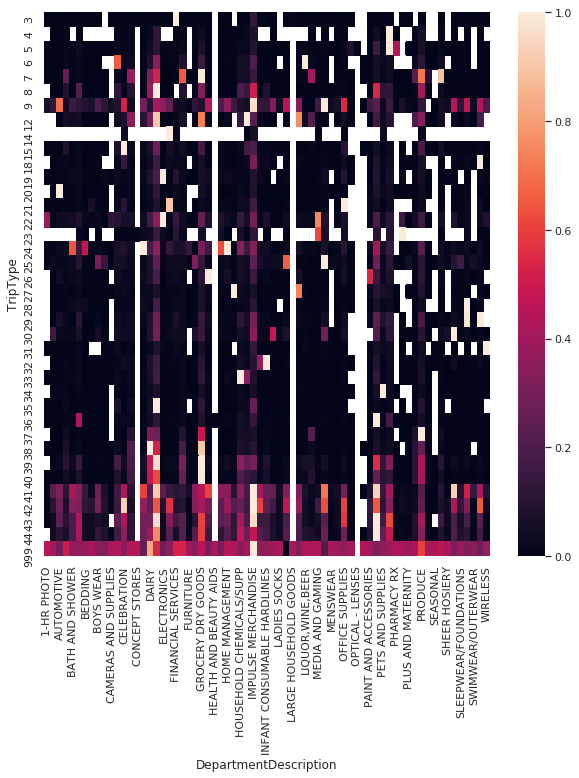

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(sub.pivot('TripType', 'DepartmentDescription', 'minmax'))

In [25]:
test = pd.read_csv('test.csv')
c = test['DepartmentDescription'].isnull()
test.loc[c, 'DepartmentDescription'] = 'Na'
test = test.groupby(['VisitNumber', 'DepartmentDescription'], as_index=False).agg(sum).iloc[:,[0, 1, 3]]

In [29]:
test.merge(sub, on=[''])

,TripType,DepartmentDescription,sum,minmax
0,3,1-HR PHOTO,2.0,0.000172
1,3,ACCESSORIES,2.0,0.000172
2,3,AUTOMOTIVE,22.0,0.003603
3,3,BAKERY,5.0,0.000686
4,3,BATH AND SHOWER,8.0,0.001201
5,3,BEAUTY,24.0,0.003946
6,3,BEDDING,4.0,0.000515
7,3,BOOKS AND MAGAZINES,4.0,0.000515
8,3,BOYS WEAR,9.0,0.001373
9,3,CAMERAS AND SUPPLIES,5.0,0.000686


# test

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 71755 entries, 119203 to 136557
Data columns (total 69 columns):
1-HR PHOTO                     71755 non-null float64
ACCESSORIES                    71755 non-null float64
AUTOMOTIVE                     71755 non-null float64
BAKERY                         71755 non-null float64
BATH AND SHOWER                71755 non-null float64
BEAUTY                         71755 non-null float64
BEDDING                        71755 non-null float64
BOOKS AND MAGAZINES            71755 non-null float64
BOYS WEAR                      71755 non-null float64
BRAS & SHAPEWEAR               71755 non-null float64
CAMERAS AND SUPPLIES           71755 non-null float64
CANDY, TOBACCO, COOKIES        71755 non-null float64
CELEBRATION                    71755 non-null float64
COMM BREAD                     71755 non-null float64
CONCEPT STORES                 71755 non-null float64
COOK AND DINE                  71755 non-null float64
DAIRY               

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

er = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, random_state=0)
er.fit(X_train, y_train)
print(classification_report(y_test, er.predict(X_test)))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       931
           4       0.90      0.32      0.47        87
           5       0.95      1.00      0.97      1167
           6       0.98      0.99      0.99       309
           7       0.97      0.99      0.98      1494
           8       0.99      1.00      0.99      3017
           9       0.97      0.99      0.98      2307
          12       0.98      0.81      0.88        62
          14       0.00      0.00      0.00         2
          15       0.94      0.94      0.94       237
          18       0.82      0.89      0.86       131
          19       0.68      0.50      0.58        80
          20       0.99      1.00      0.99       173
          21       0.97      1.00      0.98       158
          22       0.82      0.90      0.86       207
          23       0.98      0.98      0.98        43
          24       0.97      0.99      0.98       652
          25       0.96    

/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
test = df_d_sum.iloc[:, [2, 0, 1]].merge(df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')
test = test.merge(data[['TripType', 'DepartmentDescription', 'minmax']], on=['TripType', 'DepartmentDescription'])

test['val'] = test['ScanCount'] * test['minmax']

X = test.pivot('VisitNumber', 'DepartmentDescription', 'val').fillna(0)
y = X.merge(df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')['TripType']

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
param_grid = { 'n_estimators': [200, 700], 'max_features': ['auto', 'sqrt', 'log2']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)